In [227]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [228]:
priya_test=cv2.imread("./test_img/priyanka.jpg")
priya_test.shape


(898, 1497, 3)

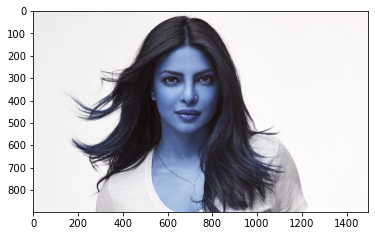

In [229]:
plt.imshow(priya_test)

In [230]:
gray=cv2.cvtColor(priya_test,cv2.COLOR_BGR2GRAY)
gray.shape

(898, 1497)

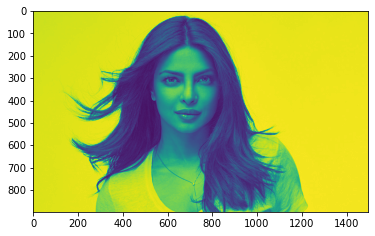

In [231]:
plt.imshow(gray)

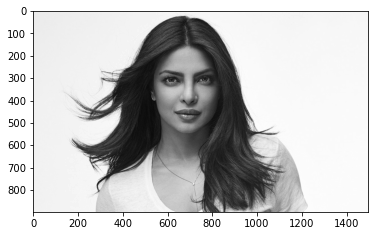

In [232]:
plt.imshow(gray,cmap='gray')

In [233]:
%matplotlib inline

In [234]:
face_cascade = cv2.CascadeClassifier('./openCV/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./openCV/haarcascades/haarcascade_eye.xml')


In [235]:
faces = face_cascade.detectMultiScale(gray,1.3,9)
faces

array([[510, 167, 369, 369]])

In [236]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

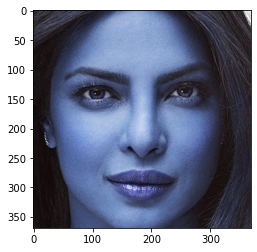

In [237]:
cropped_image = get_cropped_image_if_2_eyes("./test_img/priyanka.jpg")
plt.imshow(cropped_image)

In [238]:
path_to_data = "./Dataset/"
path_to_cr_data = "./Dataset/cropped/"

In [239]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [240]:
img_dirs

['./Dataset/K_Chawla',
 './Dataset/M_Obama',
 './Dataset/N_Ambani',
 './Dataset/O_Winfrey',
 './Dataset/P_Chopra']

In [241]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [242]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
       
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        #print(entry.path)
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                #print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            #print(cropped_file_name)
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1   

In [243]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    imArray =  np.float32(imArray)   
    imArray /= 255;
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H


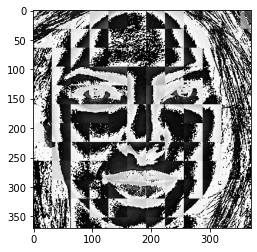

In [244]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [245]:
celebrity_file_names_dict['P_Chopra'][0]

'./Dataset/cropped/P_Chopra/P_Chopra1.png'

In [246]:
class_dict={}
count=0

for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name]=count
    count=count+1
class_dict

{'K_Chawla': 0, 'M_Obama': 1, 'N_Ambani': 2, 'O_Winfrey': 3, 'P_Chopra': 4}

In [247]:
X=[]
y=[]

for celebrity_name,training_file in celebrity_file_names_dict.items():
    for training_image in training_file:
        img=cv2.imread(training_image)
        scaled_raw_img=cv2.resize(img,(32,32))
        im_har = w2d(scaled_raw_img,'db1',5)
        scaled_img_har=cv2.resize(im_har,(32,32))
        combain_img=np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        X.append(combain_img)
        y.append(class_dict[celebrity_name])
        

In [248]:
len(X)

36

In [249]:
len(X[0])

4096

In [250]:
X=np.array(X).reshape(len(X),4096).astype(float)
X.shape

(36, 4096)

In [251]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [252]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=.25,random_state=0)
pipe=Pipeline([('scalar',StandardScaler()),('svc',SVC(kernel='linear',C=1))])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

1.0

In [253]:
len(X_test)

9

In [254]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         2

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



In [255]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [256]:
model_params = {
    'svm': {
        'model': svm.SVC(probability=True),
        'params' : {
            'svc__C': [1,10,.5,.25],
            'svc__kernel': ['rbf','linear','poly','sigmoid', 'precomputed'],
            'svc__gamma' :['auto','scale']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [257]:
X_train[0]

array([ 36.,  39.,  47., ..., 231., 238., 243.])

In [258]:
y_train[0]

4

In [259]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 188, in fit
    raise ValueError("Precomputed matrix must be a square matrix."
ValueError: Precomputed matrix must

D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 188, in fit
    raise ValueError("Precomputed matrix must be a square matrix."
ValueError: Precomputed matrix must be a square matrix. Input is a 21x4096 matrix.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit fa

D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 188, in fit
    raise ValueError("Precomputed matrix must be a square matrix."
ValueError: Precomputed matrix must be a square matrix. Input is a 21x4096 matrix.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit fa

D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 188, in fit
    raise ValueError("Precomputed matrix must be a square matrix."
ValueError: Precomputed matrix must be a square matrix. Input is a 21x4096 matrix.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit fa

D:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,model,best_score,best_params
0,svm,0.673333,"{'svc__C': 10, 'svc__gamma': 'auto', 'svc__ker..."
1,random_forest,0.560000,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.780000,{'logisticregression__C': 1}


In [260]:
best_estimators['svm'].score(X_test,y_test)

1.0

In [261]:
best_estimators['random_forest'].score(X_test,y_test)

0.4444444444444444

In [262]:
best_estimators['logistic_regression'].score(X_test,y_test)

1.0

In [263]:
best_clf=best_estimators['svm']

In [264]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,best_clf.predict(X_test))
cm

array([[1, 0, 0, 0, 0],
       [0, 2, 0, 0, 0],
       [0, 0, 3, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 2]], dtype=int64)

Text(69.0, 0.5, 'true')

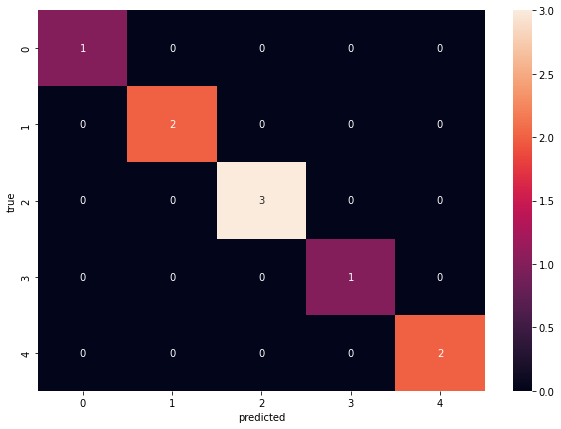

In [265]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel("predicted")
plt.ylabel("true")

In [266]:
class_dict

{'K_Chawla': 0, 'M_Obama': 1, 'N_Ambani': 2, 'O_Winfrey': 3, 'P_Chopra': 4}

In [267]:
!pip install joblib
import joblib

In [268]:
joblib.dump(best_clf,'savedceleb_model.pkl')

['savedceleb_model.pkl']

In [269]:
import json
with open("class_dictionary.json",'w')as f:
    f.write(json.dumps(class_dict))